# The Great Emu Fight

*This notebook is the culmination of the [emu-fight](https://github.com/kstoreyf/emu-fight) project, initiated at [AstroHackWeek2020](http://astrohackweek.org/2020/), by Kate Storey-Fisher, Catarina Alves, Johannes Heyl, Yssa Camacho-Neves, and Johnny Esteves.*

## Preamble

Welcome one, welcome all, to the biggest fight of the gigayear: The Great Emu Fight!

No, we don't mean this [emu fight](https://en.wikipedia.org/wiki/Emu_War):

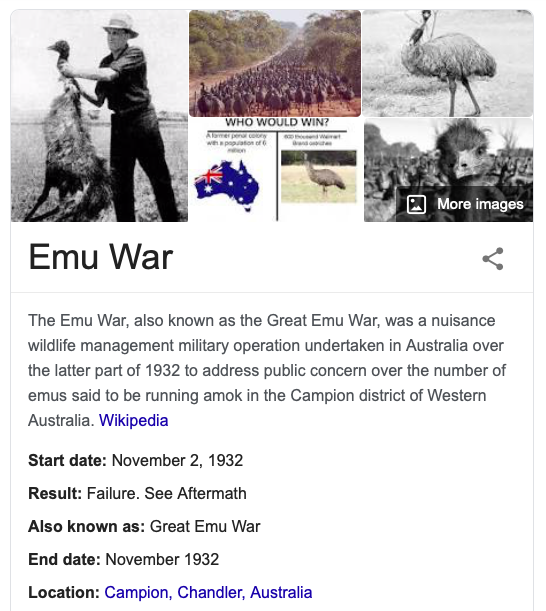

In [1]:
from IPython.display import Image
Image('images/emu_war.png', width=400)

Nor do we mean [this one](https://www.youtube.com/watch?v=d9OBqYbZ99c):

In [2]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/d9OBqYbZ99c" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/Users/ksf/miniconda3/lib/python3.7/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


We're talking about *emulators*, or "emus" for short. Like the giant Australian birds, these emus are powerful and fast. Unlike the birds, our emus are regression models that are important for astrophysics, and they're a lot less fluffy.

In this tutorial, we'll teach you what an emulator is, and show you how to build emulators with various methods and frameworks. We will then pit our emus against each other and see which emu wins!

#### Index<a name="index"></a>
1. [Theoretical Framework](#theo)
    1. [What is an emulator?](#whatEmu)
    2. [Emulation in Astrophysics](#astroEmu)
    2. [Our Dataset: The 2-Point Correlation Function](#dataEmu)
1. [Emulator war](#warPrep)
    1. [Import packages](#imports)
    2. [Plot train set](#plotTrain)
    2. [The Emulator Lineup](#lineupEmu)
        1. [Artificial Neural Network Emulator](#ann)
        2. [Decision Tree Emulator](#dt)
        3. [Random Forest Emulator](#rf)
        4. [Gaussian Process Emulators (celerite, george, GPy)](#gp)
        4. [Support Vector Machine (SVM)](#svm)
3. [Ready, Set, Fight](#warEmu)
    1. [Accuracy comparison](#accuracy)
    2. [Speed comparison](#speed)
    3. [And the winner is...](#winner)

# 1. Theoretical Framework<a name="theo"></a>

## 1.1. What is an emulator?<a name="whatEmu"></a>

Emulators imitate more complex models or simulations; they take input parameters and quickly spit out output values, without performing a physical calculation or a full simulation.

To do this, we train them on the inputs and outputs of simulations. They then learn this relationship, and for any new set of inputs, they can give an ouput. They are essentially fancy interpolators.

Let's take a simple example. Say a computational emu biologist wants to know how fast a particular emu can run. The biologist knows the emu's height, age, and fluffiness. They build a super intense simulator that takes in these demographics, and outputs the expected top speed of the bird.

The issue is that the biologist's simulator is so complicated that it takes an hour to run for each set of input parameters. This is where emulators come in. The biologist just runs a small number of simulations, sparsely spanning a reasonable range of parameter space (heights, ages, fluffiness levels). Then we train an emulator on this set of data. Now, for any other emu demographics, the emulator can quickly predict a given emu's top speed.

Why do we want an emulator of our simulation? They come in really handy for *inference*. Let's say we see an emu running at top speed down the street, breaking the city speed limit (yes, some can run this fast). But it got away, so to ID it we want to figure out its height, age, and fluffiness. If we only had the biologist's simulator, we would have to run a simulation at every possible demographic combination, and see which top speed most closely matched that of our runaway emu.

This would be untenable with the hour-long simulator. With our emulator, we can explore this parameter space much more quickly, and use techniques such as Markov Chain Monte Carlo to infer the distribution of likely bird characteristics.

## 1.2. Emulation in Astrophysics<a name="astroEmu"></a>

Alas, we are not computational emu biologists but astrophysicists. But it turns out emulators are super handy for us too! Some areas emulators have been used:
* Emulating galaxy clustering statistics for cosmological parameter inference
* Emulating stellar population synthesis models
* Emulating supernovae spectra

Here we will demonstrate our emulators on the first use case. A common problem in cosmology is inferring the cosmological parameters that govern our universe - such as the overall density of matter and baryons. We can do this by running giant simulations of fake universes where we know the input cosmological parameters. We can then measure galaxy clustering statistics (e.g. a power spectrum) on both the real and fake universes, and compare them. However, we have the same problem here as we did with the emu speed simulator: it's very slow so we can't run a simulation and get statistics at all possible parameter sets.

We can instead run a small set of simulations spanning cosmological parameter space, and compute clustering statistics on these. Then we can train an emulator on these input parameters and output statistics, and use it to find a set of cosmological parameters that generates statistics most like those we measure in our real universe.

## 1.3. Our Dataset: The 2-Point Correlation Function<a name="dataEmu"></a>

We generated a set of clustering statistics to demonstrate our emulators on. Instead of running full-blown cosmological simulations, which would take much longer than the span of this Hack Week, we used the `nbodykit` package. This can compute a model of a clustering statistic for a given cosmology in about a second - which is actually quite slow for robust inference, so our emulator is still useful! 

We choose to emulate the 2-point correlation function, the Fourier transform of the power spectrum, which measures the strength of galaxy clustering at a given spatial scale.

We vary the cosmological parameters $\Omega_m$ (the matter density), $\sigma_8$ (the amplitude of clustering), and $\Omega_b$ (the baryon density), fixing the other parameters to reasonable values. We generate a training set of 8000 correlation functions, on a uniform 3D grid of these parameters (20 points per side). We also generate a test set of 100 correlation functions, to see how our emulator did.

# 2. Emulator war preparation<a name="warPrep"></a>

## 2.1. Import packages<a name="imports"></a>

We need some specific packages so if they don't exist already, they will be downloaded.

In [3]:
try:
    import tensorflow
except ModuleNotFoundError:
    !pip install tensorflow

In [4]:
import timeit
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import emulator
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## 2.2. Plot train set<a name="plotTrain"></a>

Firstly, we plot the training set.

In [6]:
emu = emulator.emulator()
path_train = 'data/cosmology_train.pickle'
path_test = 'data/cosmology_test.pickle'
emu.read_data(path_train, path_test, scale=True, normalize_y=True)

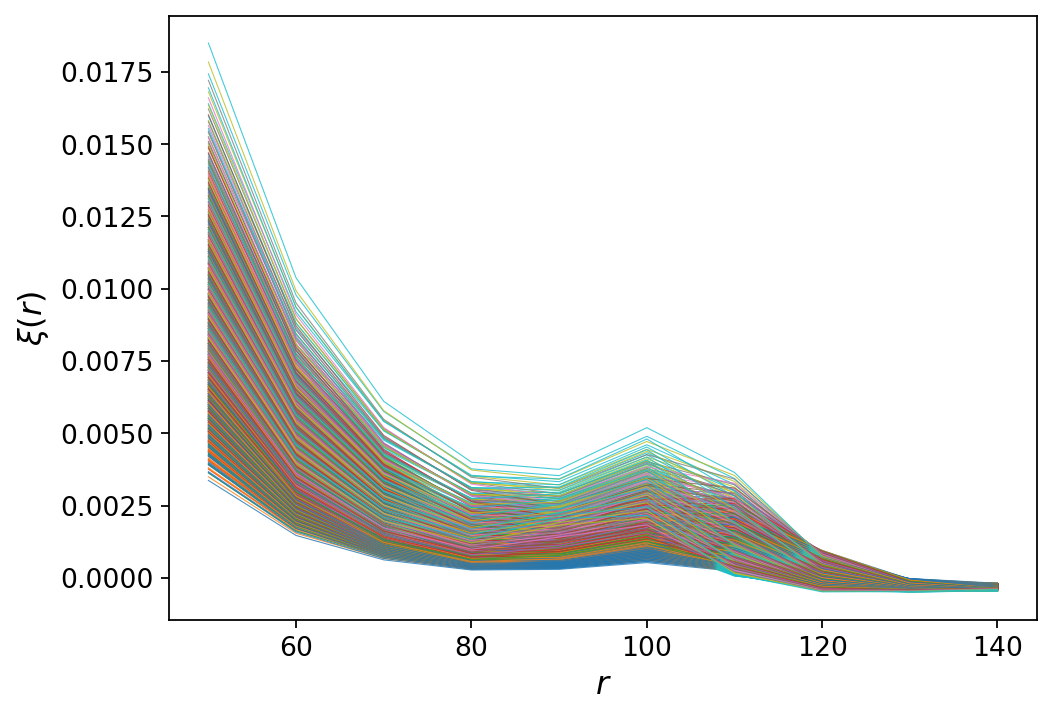

In [7]:
emu.plot_training()

The pattern is because these are in order along the grid, so parameter sets near each other have similar shapes and are plotted in that order with corresponding colors.

## 2.3. The Emulator Lineup<a name="lineupEmu"></a>

We pit a few common emulator methods against each other: 
* Artifical Neural Network
* Decision Tree 
* Random Forest
* Gaussian Process
* Support Vectorm Machine

All of these are implemented in the [`emulator.py`](https://github.com/kstoreyf/emu-fight/blob/master/emulator.py) class; check it out for details on the implementation and hyperparameters. This class also performs some basic preprocessing, including normalizing/scaling the inputs and outputs for improved training. 

For standalone notebooks constructing each of these emulators, see the [linked jupyter notebooks](https://github.com/kstoreyf/emu-fight/tree/master/emulator_examples).

We compare each on accuracy and speed. It would also be interesting to compare scaleability with respect to input parameter dimensionality; we leave this as an exercise to the reader. ;)

In [8]:
run_timeit = True
from collections import defaultdict
time_dict = defaultdict(dict)

In [9]:
regressor_names = emu.regressors_implemented
x = np.arange(len(regressor_names))
colors = np.array([plt.cm.Dark2(xx) for xx in x])

### 2.3.1 Artificial Neural Network Emulator<a name="ann"></a>

An [Artificial Neural Network (ANN)](https://towardsdatascience.com/introduction-to-artificial-neural-networks-ann-1aea15775ef9) is a class of machine learning methods loosely modeled after the neural connections in biological systems. It is also known as a Multi-Layer Perceptron (MLP), with layers that give various weights to input features. It uses an activation function to convert inputs to outputs and learn more complex functions. ANNs can be used for both classification and regression.

ANNs are useful for emulation as they can model complicated function spaces, with high-dimensional features. Here we use the scikitlearn implementation of an MLP regressor.

For a stand-alone walkthrough of constructing this emulator, see [`emulator_ANN_sklearn.ipynb`](https://github.com/kstoreyf/emu-fight/blob/master/emulator_examples/emulator_ANN_sklearn.ipynb).

In [10]:
if run_timeit:
    t = %timeit -o emu.train("ANN")
    time_dict["ANN"]["train_mean"] = t.average
    time_dict["ANN"]["train_std"] = t.stdev
else:
    emu.train("ANN")

1.96 s ± 25.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
if run_timeit:
    t = %timeit -o emu.predict_test_set("ANN")
    time_dict["ANN"]["test_mean"] = t.average
    time_dict["ANN"]["test_std"] = t.stdev
else:
    emu.predict_test_set("ANN")

1.09 ms ± 56.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


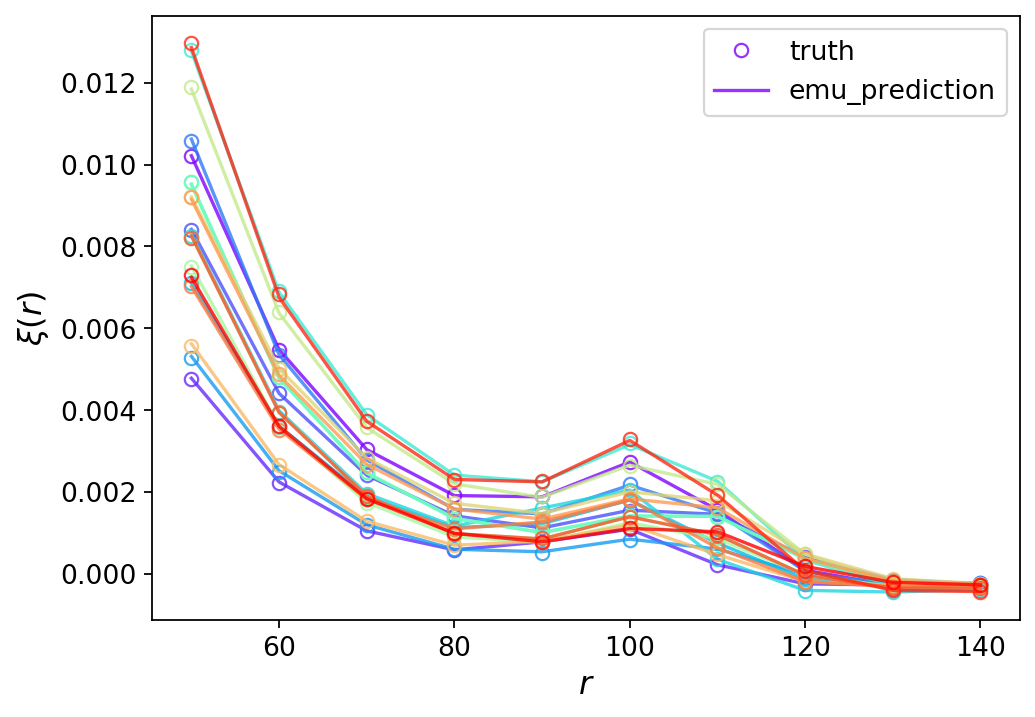

In [12]:
emu.plot_predictions("ANN")

### 2.3.2. Decision Tree Emulator<a name="dt"></a>

[Decision trees](https://www.saedsayad.com/decision_tree_reg.htm) are regression or classification models in the form of a tree structure. They are among the most popular machine learning algorithms given their intelligibility and simplicity.

For a stand-alone walkthrough of constructing this emulator, see [`emulator_dtree.ipynb`](https://github.com/kstoreyf/emu-fight/blob/master/emulator_examples/emulator_dtree.ipynb).

In [13]:
if run_timeit:
    t = %timeit -o emu.train("DTree")
    time_dict["DTree"]["train_mean"] = t.average
    time_dict["DTree"]["train_std"] = t.stdev
else:
    emu.train("DTree")

138 ms ± 7.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
if run_timeit:
    t = %timeit -o emu.predict_test_set("DTree")
    time_dict["DTree"]["test_mean"] = t.average
    time_dict["DTree"]["test_std"] = t.stdev
else:
    emu.predict_test_set("DTree")

700 µs ± 53.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


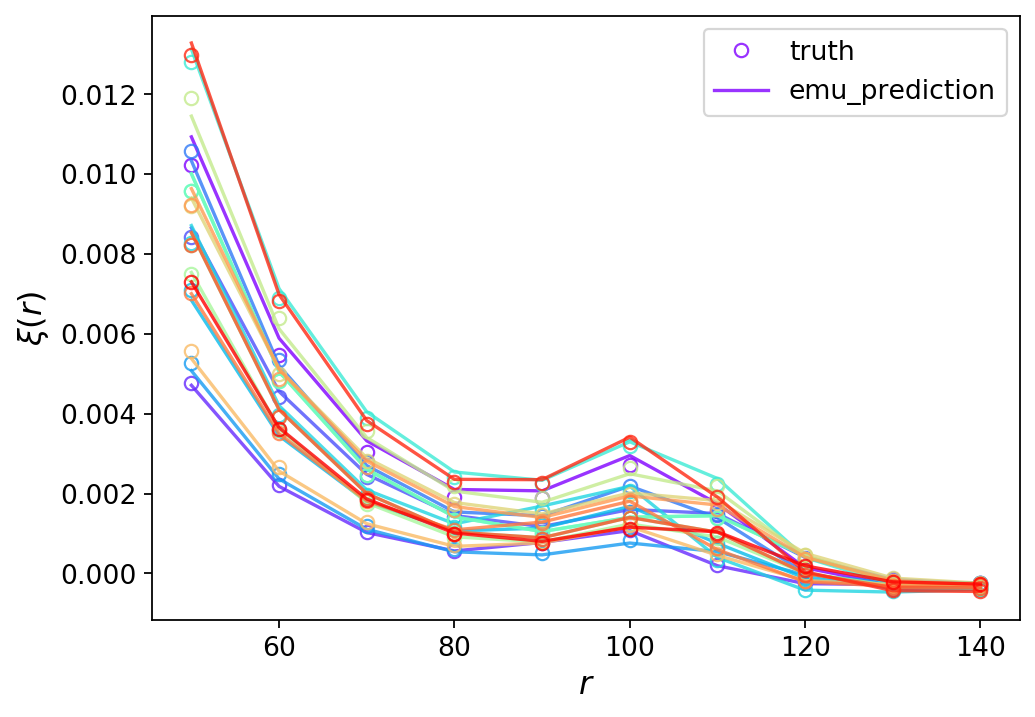

In [15]:
emu.plot_predictions("DTree")

### 2.3.3. Random Forest Emulator<a name="rf"></a>

A [Random Forest](https://builtin.com/data-science/random-forest-algorithm) regressor is an example of an ensemble learning method. During training, multiple decision trees are generated. Each tree is trained on a different subset of the data. Each tree overfits on the different subsamples of data and features. However, by averaging over all the different trees, the overall variance of the forest is lower.

For a stand-alone walkthrough of constructing this emulator, see [`emulator_RF_sklearn.ipynb`](https://github.com/kstoreyf/emu-fight/blob/master/emulator_examples/emulator_RF_sklearn.ipynb).

In [16]:
if run_timeit:
    t = %timeit -o emu.train("RF")
    time_dict["RF"]["train_mean"] = t.average
    time_dict["RF"]["train_std"] = t.stdev
else:
    emu.train("RF")

1.61 s ± 153 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
if run_timeit:
    t = %timeit -o emu.predict_test_set("RF")
    time_dict["RF"]["test_mean"] = t.average
    time_dict["RF"]["test_std"] = t.stdev
else:
    emu.predict_test_set("RF")

72.8 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


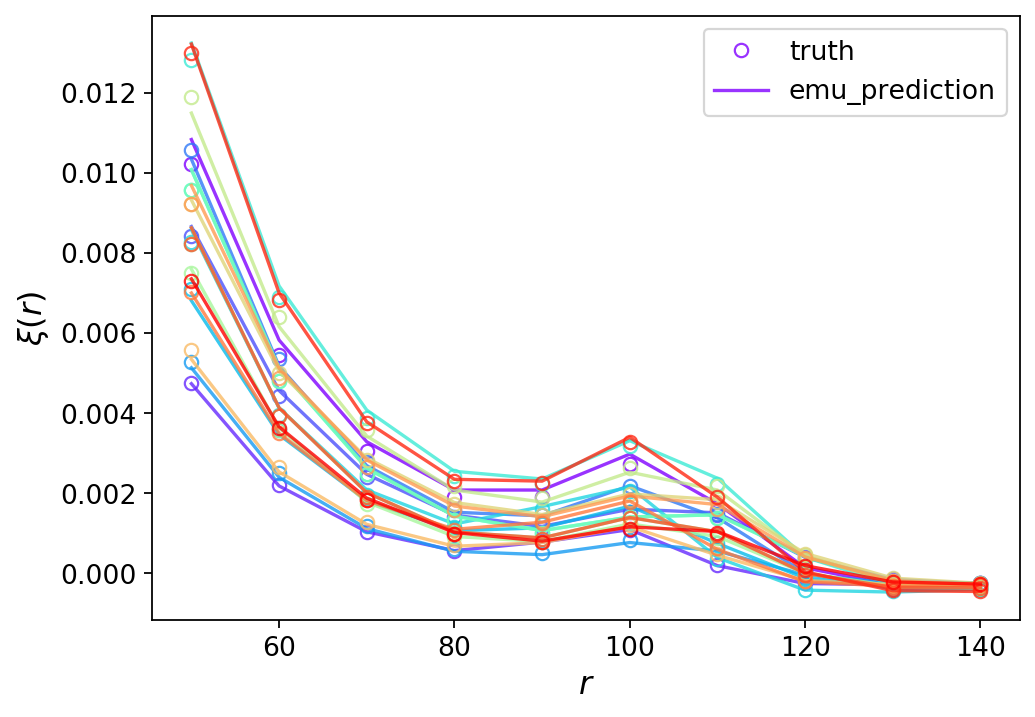

In [18]:
emu.plot_predictions("RF")

### 2.3.4. Gaussian Process Emulators (celerite, george)<a name="gp"></a>

The idea behind Gaussian Processes (GPs) is to use Gaussian distributions (also referred to as *normal* distributions), defined by a mean vector and a covariance matrix (also called kernel), to predict a function at certain *test* points.

There are many GP Python libraries that are commonly used to solve regression problems. The two we used here are [Celerite](https://celerite.readthedocs.io/en/stable/) and [George](https://george.readthedocs.io/en/latest/). Both of these libraries use a kernel-based, Bayesian method of regression. A visual exploration of GPs can be found [A Visual Exploration of Gaussian Processes](https://distill.pub/2019/visual-exploration-gaussian-processes/) and a more complete theory behind GPs can be found for free at [ Rasmussen & Williams (2006)](http://www.gaussianprocess.org/gpml/)

Each GP library has their own choice of built-in kernels and the option to build your own. The choice of kernel can make a big difference on the success of the regression and finding the best kernel for your own dataset is a bit of an art. Each GP library also has their own strengths and limitations. 

In terms of using them as emulators we found that George provides good regression models, is able to build GP regressors in 2 or 3 dimensions, but it takes a long time to emulate. Celerite on the other hand is a very fast way to build regressors but it is limited to 1 dimension and is not very accurate in fitting datasets with multiple inputs. 

For stand-alone walkthroughs of constructing these emulators, see [`emulator_gp_george.ipynb`](https://github.com/kstoreyf/emu-fight/blob/master/emulator_examples/emulator_gp_george.ipynb) and see [`emulator_gp_celerite.ipynb`](https://github.com/kstoreyf/emu-fight/blob/master/emulator_examples/emulator_gp_celerite.ipynb).

[TODO: load, train, and test emulator]

### 2.3.5. Support Vector Machine (SVM) <a name="svm"></a>

A [Suport Vector Machine (SVM)](https://www.saedsayad.com/support_vector_machine_reg.htm) is a supervised learning algorithm that can be employed in classification and regression tasks. Here we use SVM for regression analysis purposes. 

The Support Vector Regression (SVR) uses the same principles as the SVM for classification, with only a few minor differences. A margin is defined not to separate between two classes but instead is used to define the region of intereset ($\epsilon$). 

The main idea is: to minimize error, individualizing the hyperplane which maximizes the margin, keeping in mind that part of the error is tolerated.  

Usually, SVM is better in small samples than the other methods.

For a stand-alone walkthrough of constructing this emulator, see [`emulator_svm.ipynb`](https://github.com/kstoreyf/emu-fight/blob/master/emulator_examples/emulator_svm.ipynb).

In [19]:
if run_timeit:
    t = %timeit -o emu.train("SVM")
    time_dict["SVM"]["train_mean"] = t.average
    time_dict["SVM"]["train_std"] = t.stdev
else:
    emu.train("SVM")

29.6 s ± 1.21 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
if run_timeit:
    t = %timeit -o emu.predict_test_set("SVM")
    time_dict["SVM"]["test_mean"] = t.average
    time_dict["SVM"]["test_std"] = t.stdev
else:
    emu.predict_test_set("SVM")

5.12 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


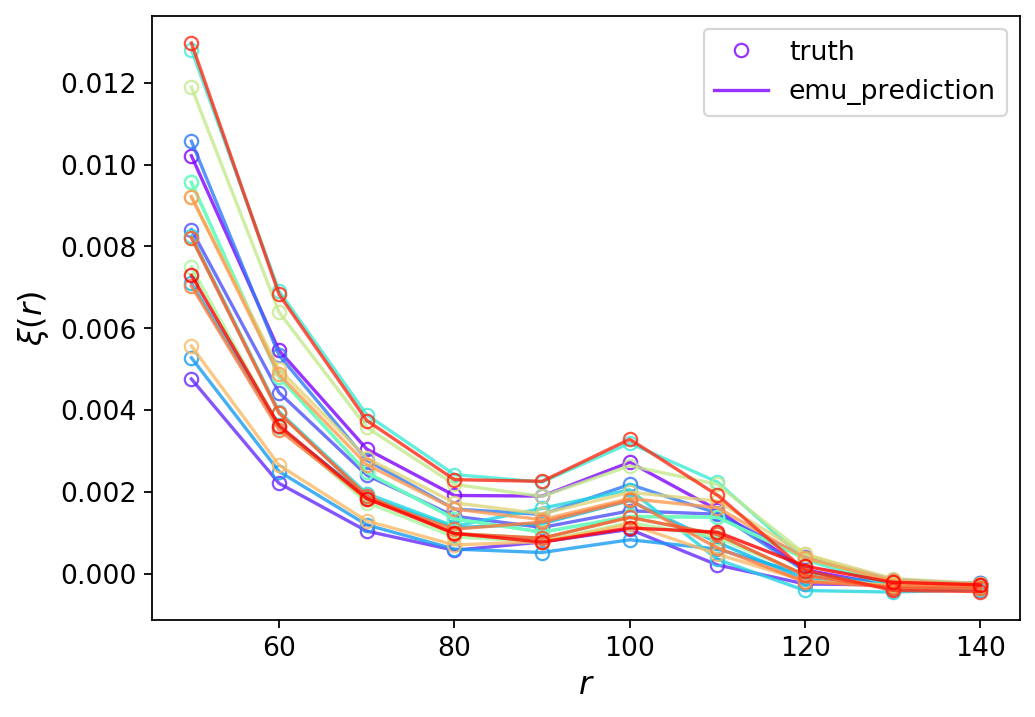

In [21]:
emu.plot_predictions("SVM")

# 3. Ready, Set, Fight<a name="warEmu"></a>

## 3.1. Accuracy comparison<a name="accuracy"></a>

We can now compare the accuracy of the emulators! We use the validation statistics we measured for each, and plot them against each other, as a function of the bins.

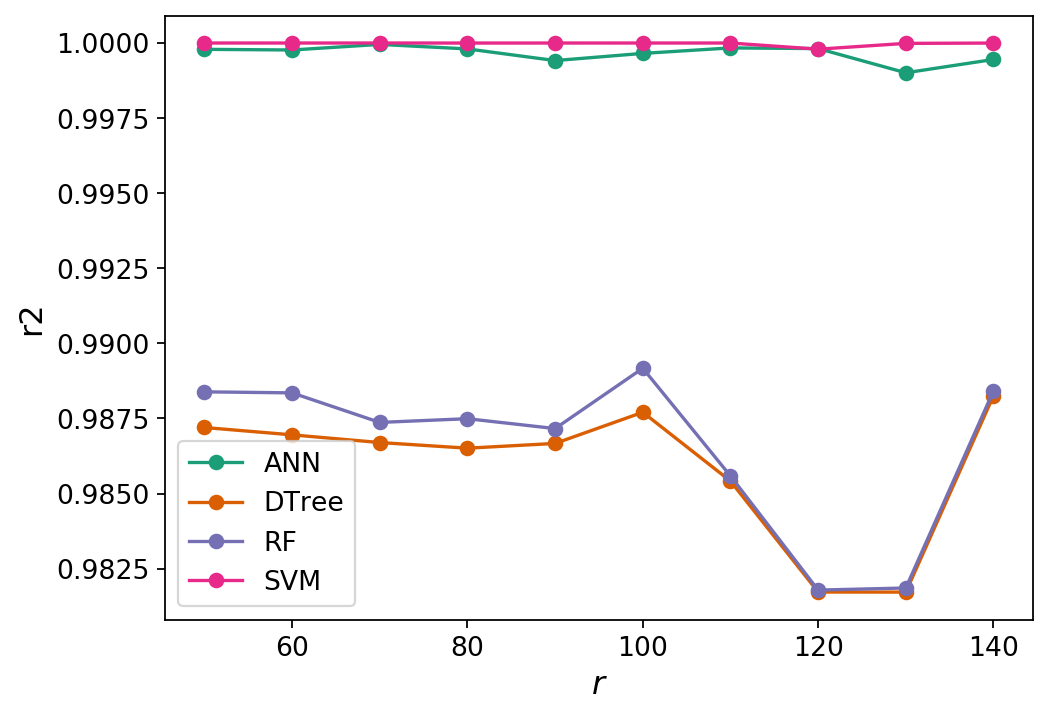

In [22]:
metric = "r2"
emu.test_all(metric)
emu.plot_accuracy(metric, colors=colors)

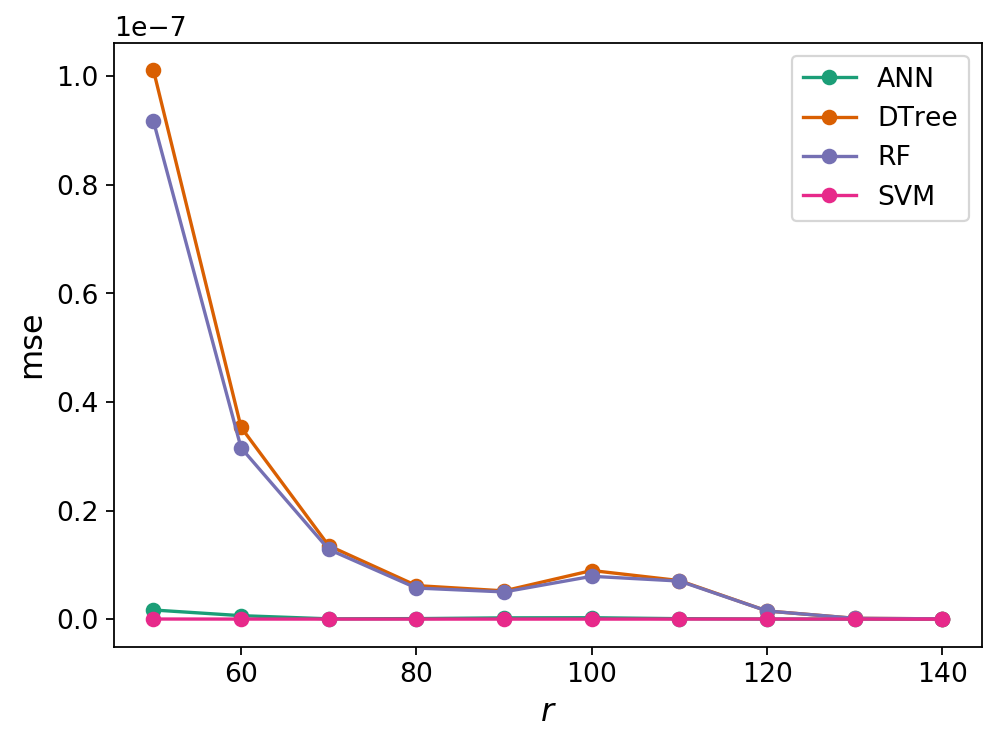

In [23]:
metric = "mse"
emu.test_all(metric)
emu.plot_accuracy(metric, colors=colors)

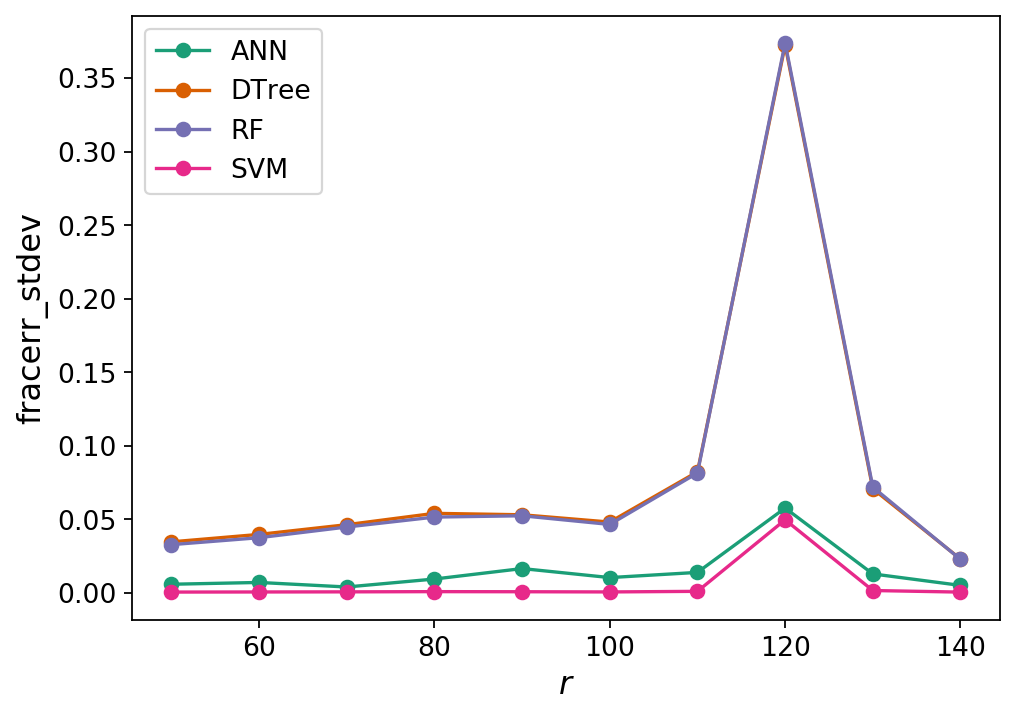

In [24]:
metric = "fracerr_stdev"
emu.test_all(metric)
emu.plot_accuracy(metric, colors=colors)

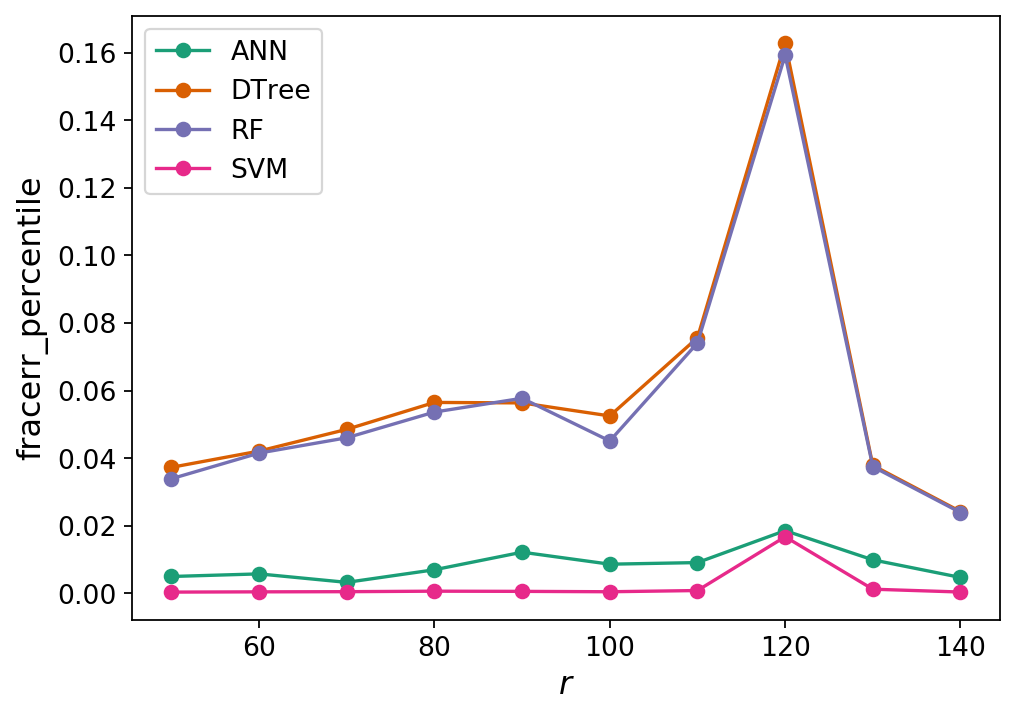

In [25]:
metric = "fracerr_percentile"
emu.test_all(metric)
emu.plot_accuracy(metric, colors=colors)

We can see that for both of these accuracy metrics on this dataset, the ANN is winning! 

However, we caution that while we have done our best to tune the hyperparameters, there may be better sets of hyperparameters that improve each model. The performance will also compare differently on different datasets.

## 3.2. Speed comparison<a name="speed"></a>

Let's first look at how long our emulators took to train. With the jupyter magic `%timeit`, we measured the average and uncertainty of seven training runs.

Text(0, 0.5, 'train time (s)')

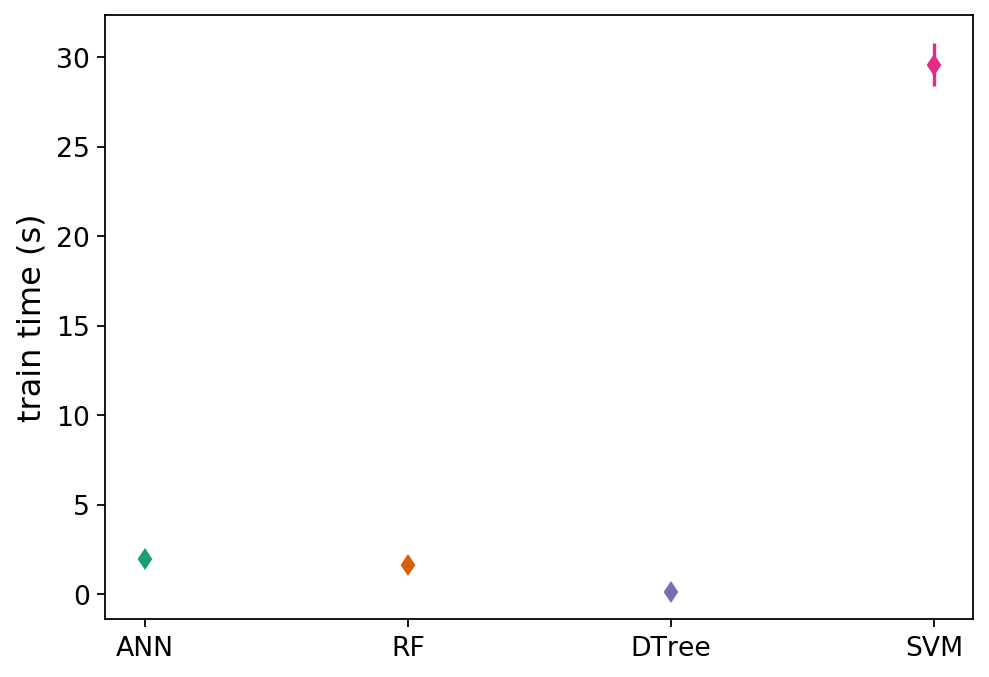

In [26]:
ax = plt.gca()
for i, rn in enumerate(regressor_names):
    ttrain = time_dict[rn]['train_mean']
    strain = time_dict[rn]['train_std']
    ax.errorbar(x[i], ttrain, yerr=strain, ls='None', marker='d', color=colors[i])

ax.set_xticks(x)
ax.set_xticklabels(regressor_names)
ax.set_ylabel("train time (s)")

Now let's check out prediction times; this is on our whole test set, which is this many prediction calls:

In [27]:
"Number of test statistics:", emu.ys_train_orig.shape[0]

('Number of test statistics:', 1000)

Text(0, 0.5, 'test time (s)')

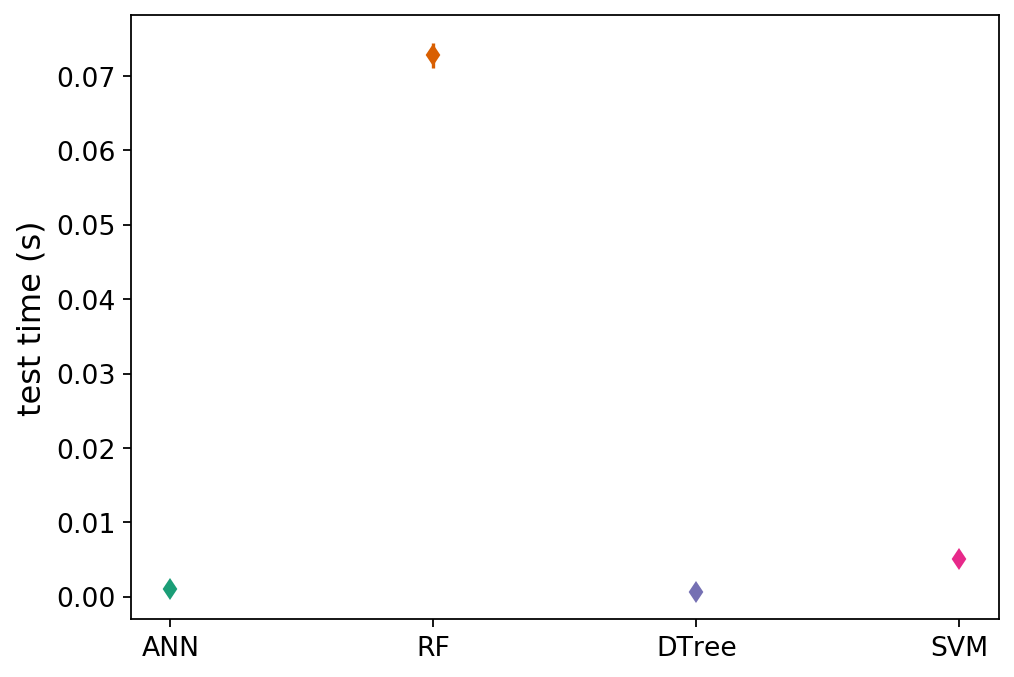

In [28]:
ax = plt.gca()
for i, rn in enumerate(regressor_names):
    ttest = time_dict[rn]['test_mean']
    stest = time_dict[rn]['test_std']
    ax.errorbar(x[i], ttest, yerr=stest, ls='None', marker='d', color=colors[i])

ax.set_xticks(x)
ax.set_xticklabels(regressor_names)
ax.set_ylabel("test time (s)")

## 3.3. And the winner is...<a name="winner"></a>

...it depends how you measure winning! All emulators are winners in their own way!

Okay, that's not a very satisfying answer, so let's see what we found out about the performance of each type of emulator.

In terms of accuracy, the **ANN** and **SVM** way outperform the RF and DTree across all metrics. Between the two top spots, the **SVM** shines as the pretty clear winner.

However, the SVM's accuracy comes at the expense of time. It is by far the slowest to train, taking nearly an order of magnitude longer. The **DTree** is the winner in training time, though as we saw its accuracy was subpar.

The SVM also has slightly longer prediction times than the competing **ANN**; the **ANN** and **DTree** win when it comes to test time.

(While we don't want to rub it in, the **RF** is a pretty clear loser here. Whomp whomp.)

Finally, it's super important to note that all of these performance metrics depend on the exact implementation and hyperparameters of the emulator. For example, our `scikit-learn` ANN will likely have very different results than a custom `tensorflow` implementation. Further, each of us has done our best to tune the hyperparameters of the emulators to achieve the best results on this dataset, such as the learning rate and kernel; but these could all likely be improved with more tuning.

We should also emphasize the massaging we did with our data in the first place! We performed a scaling on our x-data to normalize them to between 0 and 1, and we also did a basic normalization on our output statistic (dividing it by the mean of the training data). These were very important in getting reasonable emulators at all; don't forget about this step if you're working with a new dataset!

Thank you for witnessing *The Great Emu Fight*! If you'd like to throw your emu into the ring, or try emulating your own dataset, follow the instructions on  [contributing](https://github.com/kstoreyf/emu-fight#contributing).

[Go back to top.](#index)